In [1]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier
from datasets.cls_dataset import RSNAImageClsDataset  # Using RSNA dataset now
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

/Users/sandradening/anaconda3/envs/CAMP/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/Users/sandradening/anaconda3/envs/CAMP/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/sandradening/anaconda3/envs/CAMP/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2

### Functions

In [3]:
def extract_embeddings(model, dataloader): #should be the same function you used
    model.eval()  
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            feats, labels = model.shared_step(batch, return_embeddings=True)
            all_feats.append(feats.cpu())  
            all_labels.append(labels.cpu())

    all_feats = torch.cat(all_feats)
    all_labels = torch.cat(all_labels)
    return all_feats, all_labels

In [21]:
def plot_embeddings(embeddings_2d, labels, class_names, title, path_to_save):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        # Flatten the labels to ensure correct indexing
        idx = labels.ravel() == class_idx  # Make sure labels are 1D
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title(f"{title} - t-SNE Visualization of Image Embeddings")
    #save as high res image
    plt.savefig(path_to_save, format="pdf", dpi=300)
    plt.show()

### Get Embeddings and Plot embeddings

In [5]:
# Load config for RSNA dataset
config = load_config('../configs/rsna.yaml')
config["dataset"]["train_csv"]

Loading configuration from: ../configs/rsna.yaml


'/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/VLP-Seminar/annotations/rsna/balancedtrain.csv'

In [6]:
finetuned_rsna = FinetuneClassifier(config) #init model


#adapt checkpoint path..
checkpoint_path = '/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/data/ckpts/FinetuneCLS/rsna/2025_01_17_14_27_25/epoch=27-step=8147.ckpt'


checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']

#(I had to do that since there were some architecture issues)
# Remove the keys corresponding to the extra layers 
for key in list(state_dict.keys()):
    if "classification_head.block_forward.3" in key or "classification_head.block_forward.6" in key:
        state_dict.pop(key)

#finetuned_rsna.load_state_dict(state_dict)
finetuned_rsna.load_state_dict(state_dict, strict=False) #try strict= False if not working

/Users/sandradening/anaconda3/envs/CAMP/lib/python3.10/site-packages/pytorch_lightning/core/lightning.py:2054: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook


_IncompatibleKeys(missing_keys=['classification_head.block_forward.3.weight', 'classification_head.block_forward.3.bias', 'classification_head.block_forward.3.running_mean', 'classification_head.block_forward.3.running_var', 'classification_head.block_forward.3.num_batches_tracked', 'classification_head.block_forward.6.weight', 'classification_head.block_forward.6.bias'], unexpected_keys=[])

In [8]:
# RSNA DataModule (binary classification task)
datamodule = DataModule(dataset=RSNAImageClsDataset, 
                        config=config, collate_fn=None,
                        transforms=DataTransforms, data_pct=1,
                        batch_size=64, num_workers=16)

In [9]:
datamodule.print_dataset_sizes()

Dataset size of split train: 8416
Dataset size of split valid: 1804
Dataset size of split test: 1804
Training dataset size: 8416
Validation dataset size: 1804
Test dataset size: 1804


In [10]:
test_dataloader = datamodule.test_dataloader() 
test_feats, test_labels = extract_embeddings(finetuned_rsna, test_dataloader) # extract embeddings

print(test_feats.shape)  # (num_samples, embedding_dim)
print(test_labels.shape)

Dataset size of split test: 1804
torch.Size([1804, 2048])
torch.Size([1804, 1])


In [11]:
#this cell took forever

embeddings_np = test_feats.numpy()
labels_np = test_labels.numpy()

# Normalize embeddings 
scaler = StandardScaler()
embeddings_np = scaler.fit_transform(embeddings_np)

tsne = TSNE(n_components=2, perplexity=30, random_state=42) #apply tsne
embeddings_2d = tsne.fit_transform(embeddings_np)

In [12]:
embeddings_2d

array([[-60.44561  ,  -1.9421661],
       [ 53.31641  , -18.042858 ],
       [ 27.32366  , -22.902105 ],
       ...,
       [-47.945293 ,  -8.560796 ],
       [  4.897239 ,  -9.618794 ],
       [ 28.432558 ,  29.72289  ]], dtype=float32)

In [18]:
import pickle
with open('rsna_embeddings_medclip_balanced.pkl', 'wb') as f:
    pickle.dump((embeddings_np, labels_np, embeddings_2d), f)

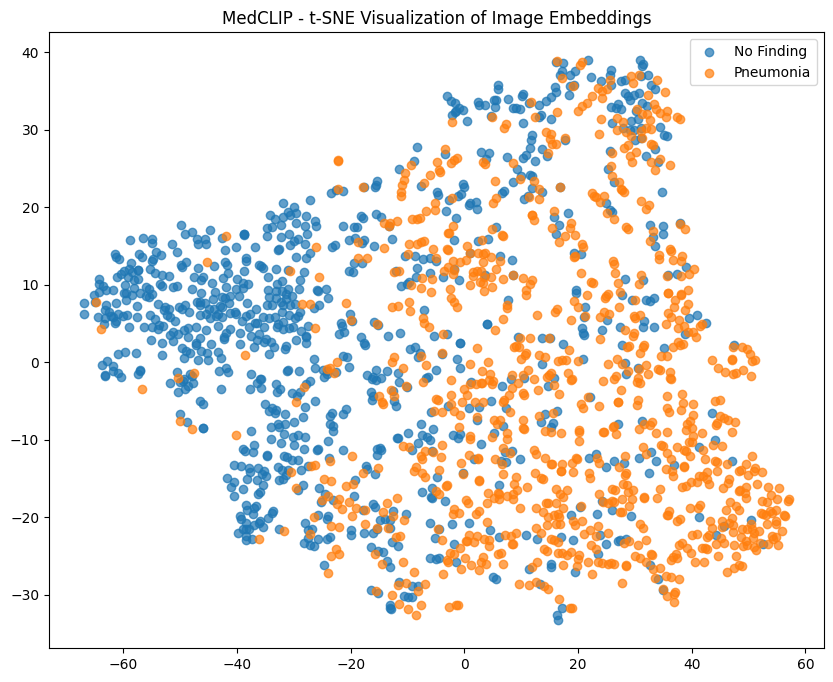

In [22]:
class_names = ["No Finding", "Pneumonia"]  
plot_embeddings(embeddings_2d, labels_np, class_names, "MedCLIP", "rsna_embeddings_medclip_balanced.pdf")

### Compute Cluster scores

MedCLIP 

In [26]:
from sklearn.metrics import silhouette_score

#Measures how similar each point is to its own cluster compared to other clusters
#Values range from -1 (bad clustering) to 1 (perfect clustering)
#Recommended if: You have at least two distinct clusters and want a simple metric for cohesion and separation.

silhouette_avg = silhouette_score(embeddings_2d, labels_np) 
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.20531508326530457


In [27]:
from sklearn.metrics import calinski_harabasz_score

#measures the ratio of between-cluster dispersion to within-cluster dispersion
#value: the higher the better
#Recommended if: You want a score that rewards well-separated clusters with low within-cluster variance

ch_index = calinski_harabasz_score(embeddings_2d, labels_np)
print(f"Calinski-Harabasz Index: {ch_index}")

Calinski-Harabasz Index: 598.1474911357625
